/tmp/ipykernel_916947/1008463191.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = plt.cm.get_cmap('tab10')  # 최대 10가지 뚜렷한 색


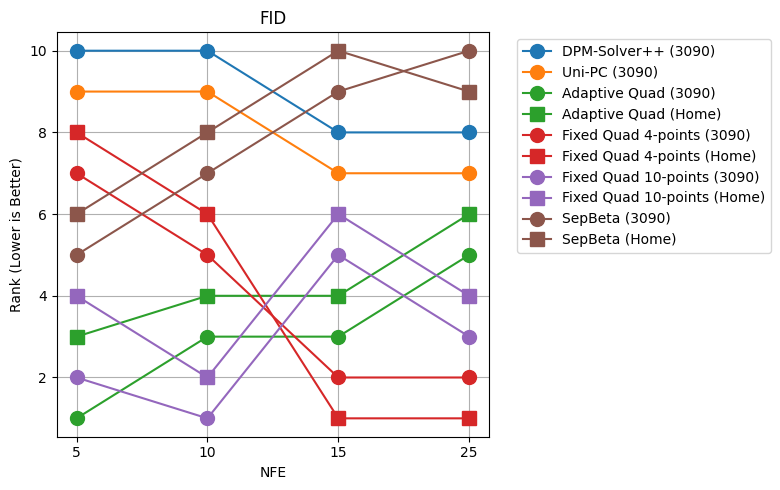

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 예시 데이터
data = {
    "DPM-Solver++": {
        "3090": [110.11, 28.90, 21.82, 19.55],
    },
    "Uni-PC": {
        "3090": [109.47, 27.82, 21.40, 19.20],
    },
    "Adaptive Quad": {
        "3090": [69.99, 24.49, 20.43, 18.97],
        #"4090": [69.79, 25.75, 20.07, np.nan],  # 25에서 error
        "Home": [70.08, 24.55, 20.48, 18.98],
    },
    "Fixed Quad 4-points": {
        "3090": [90.86, 25.62, 19.40, 17.93],
        #"4090": [73.42, np.nan, 20.07, 18.48],  # 10에서 error
        "Home": [90.97, 25.76, 19.35, 17.82],
    },
    "Fixed Quad 10-points": {
        "3090": [69.99, 24.40, 20.99, 18.86],
        #"4090": [74.03, 25.76, 20.54, np.nan],  # 25에서 error
        "Home": [70.08, 24.48, 21.08, 18.87],
    },
    "SepBeta": {
        "3090": [79.23, 25.86, 22.40, 26.40],
        #"4090": [84.05, 26.12, 22.67, np.nan],
        "Home": [80.44, 26.46, 23.16, 24.34],
    },
}

# 스텝 목록
steps = [5, 10, 15, 25]

# 모델 목록 (원하는 순서대로)
model_list = [
    "DPM-Solver++",
    "Uni-PC",
    "Adaptive Quad",
    "Fixed Quad 4-points",
    "Fixed Quad 10-points",
    "SepBeta",
]

# 환경 순서 (원하시는 환경 순서를 지정)
env_list = ["3090", "4090", "Home"]

# (1) tab10 컬러맵에서 모델별 색상 추출
tab10 = plt.cm.get_cmap('tab10')  # 최대 10가지 뚜렷한 색
model_colors = {}
for i, model_name in enumerate(model_list):
    model_colors[model_name] = tab10(i)

# (2) 환경별 마커
env_markers = {
    "3090": 'o',   # 동그라미
    "4090": '^',   # 사각형
    "Home": 's',   # 세모
}

# (모델, 환경) 조합을 만들되, model_list와 env_list 순서를 따름
ordered_combos = []
for model_name in model_list:
    if model_name in data:
        for env_name in env_list:
            if env_name in data[model_name]:
                ordered_combos.append((model_name, env_name))

# (모델, 환경)별 step별 rank 저장을 위한 딕셔너리
rank_dict = {(m, e): [np.nan]*len(steps) for (m, e) in ordered_combos}

# 각 스텝별 랭크 계산
for i, step in enumerate(steps):
    valid_combo_times = []
    for (m, e) in ordered_combos:
        vals = data[m].get(e, None)
        if vals is not None and len(vals) > i:
            t = vals[i]
            if not np.isnan(t):
                valid_combo_times.append((m, e, t))

    # 시간 기준으로 오름차순 정렬
    valid_combo_times.sort(key=lambda x: x[2])
    
    # 1등부터 rank 부여
    for rank, (m, e, t) in enumerate(valid_combo_times, start=1):
        rank_dict[(m, e)][i] = rank

# 그래프 그리기
plt.figure(figsize=(8, 5))
xvals = np.arange(len(steps))  # [0, 1, 2, 3]

for (m, e) in ordered_combos:
    ranks = rank_dict[(m, e)]
    color = model_colors.get(m, 'k')   # 모델별 색
    marker = env_markers.get(e, 'x')   # 환경별 마커 (없으면 'x')
    
    # label: "모델 (환경)" 형태로 표시
    label_name = f"{m} ({e})"
    
    plt.plot(
        xvals,
        ranks,
        color=color,
        marker=marker,
        markersize=10,  # <----- 마커 크기를 원하는만큼 설정
        label=label_name
    )

plt.xticks(xvals, steps)
plt.xlabel("NFE")
plt.ylabel("Rank (Lower is Better)")
plt.title("FID")
plt.grid(True)

# (선택) 1등이 위에 오도록 하려면 아래 주석 해제
# plt.gca().invert_yaxis()

# 범례를 오른쪽에 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
